# COMPSCI 590.07 Assignment 1: MDPs and Value Functions


Name: **Bernie Cassidy**

Welcome to Assignment 1. This notebook will help you understand:
- Markov Decision Processes (MDPs).
- Policy Evaluation and Policy Improvement.
- Value and Policy Iteration.
- Bellman Equations.

Please answer the written questions in a separate document.

## Preliminaries
You'll need three imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- matplotlib: Used for scientific visualization of data in Python
- mdp: A module containing an abstract MDP class. This module is included in the file present in folder.
- tools: This module contains the visualization tools we use in our assignment


There are also some other lines in the cell below that are used for grading and plotting &mdash; you needn't worry about them.

In this notebook, all cells are locked except those that you are explicitly asked to modify. It is up to you to decide how to implement your solution in these cells, **but please do not import other libraries** &mdash; doing so will break the autograder.

In [241]:
%%capture
%matplotlib inline

In [242]:
import copy
import numpy as np
from mdp import MDP
import tools

## Section 1: Defining MDPs

In this first assignment, we'll be implementing and solving the grid world from Russell and Norvig's book.

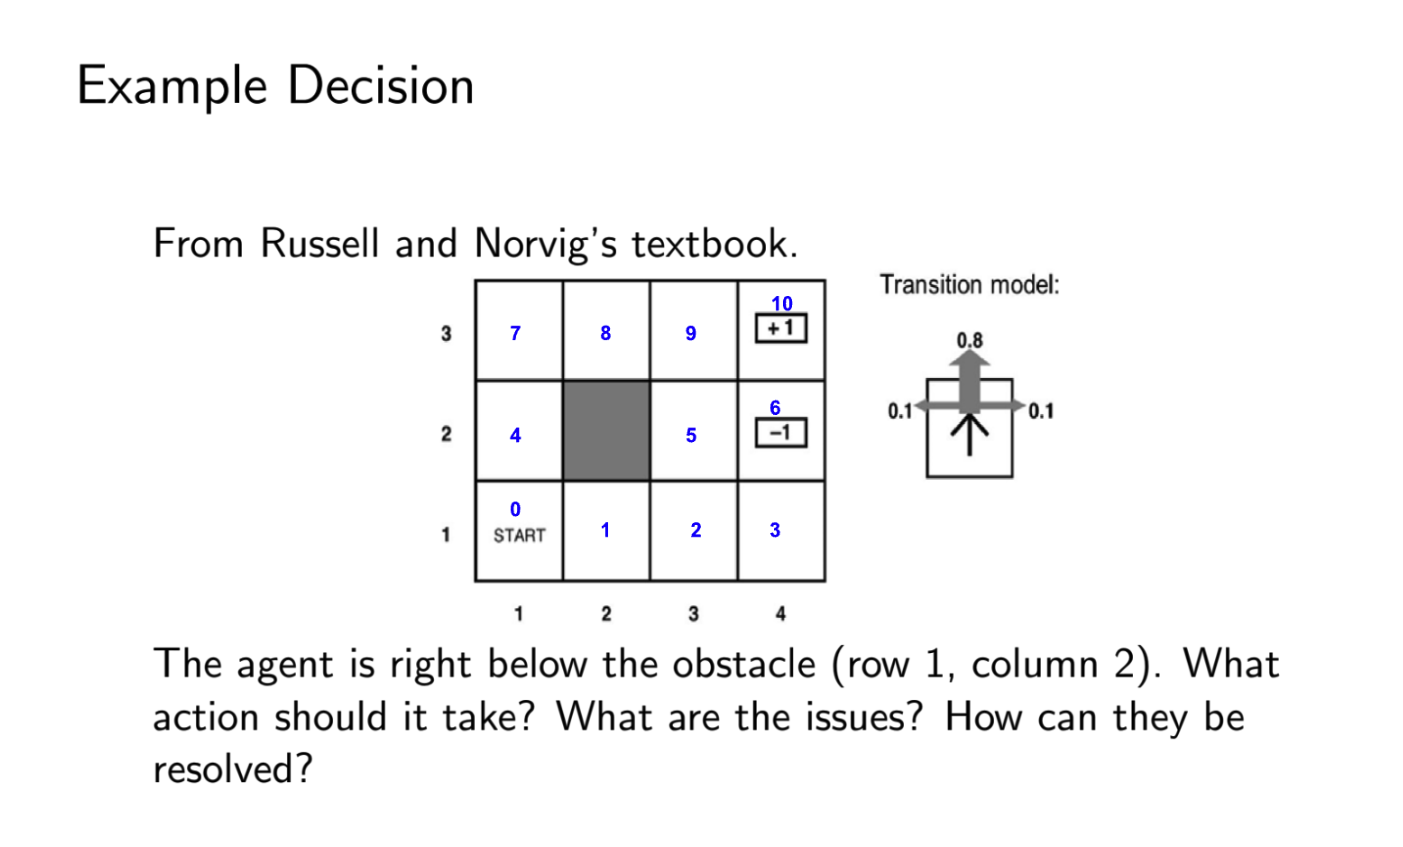

In this grid world, states are represented by cells in a grid.
The agent occupies cells in the grid world, and moves between cells
to try and reach the top-right goal cell.

The agent can move in its four cardinal directions (and so has four actions,
NORTH, EAST, SOUTH, WEST).
Attempting to move into a wall (outside the grid) or into the obstacle (the block between states 4 and 5) results in the agent remaining in the same state.
Once the agent reaches a rewarding state (state 10 or state 6, with rewards +1 and âˆ’1 respectively), the environment terminates.

Transitions in the MDP have a chance of "slipping": with p = 0.1,
the agent will move in either right or left of its intended direction.
For example, if the agent wants to move NORTH, it has a 0.8 probability of doing so,
and 0.1 probability of moving EAST and a 0.1 probability of moving WEST.

The two terminal states (+1, -1) are denoted by self-transition probabilities of 1
(no matter what action the agent takes, it remain in the same states). All actions taken from the two rewarding states results in a reward of +1 or -1. All other states and actions give 0 reward.

States are indexed from left to right, bottom to top. The indices are denoted in blue. The actions are indexed from 0 to 3, in order of NORTH, EAST, SOUTH, WEST. Notice how we don't index the box at row 2, column 2 as a state, thats becuase the agent can never go into that block because of an obstacle.

As an example, the START state/cell is index 0,
and the terminal state/cell with reward +1 is index 10.




In [243]:
# [GRADED]
class GridWorld(MDP):
    def __init__(self, gamma: float = 0.9):
        """
        Construct the GridWorld MDP tensors.
  - T: transition tensor, shape (A, S, S)
      T[a, s, s'] = P(S_{t+1} = s' | S_t = s, A_t = a)
      Example: T[0, 0, 4] = 0.9 (probability of transitioning to state 4 from state 0
           upon taking action NORTH)
  - R: expected immediate rewards, shape (A, S)
      R[a, s] = E[R_{t+1} | S_t = s, A_t = a]
      Example: R[0, 4] = 0 (the reward from the current state 4 taking action NORTH)
  - p0: initial state distribution, shape (S,)
      p0[s] = P(S_0 = s)
      Example: p0[0] = 1.0 (the agent always starts at state 0)

  For clarity, we first construct one transition matrix per action:
  - T_up, T_down, T_left, T_right âˆˆ R^{SÃ—S}
    T_up[s, s'] = P(S_{t+1} = s' | S_t = s, A_t = UP)
    (analogously for the other actions)

  These action-specific matrices are then stacked into the full tensor:
  T[UP] = T_up, T[DOWN] = T_down, T[LEFT] = T_left, T[RIGHT] = T_right.

  Each row T[a, s, :] is a probability distribution (sums to 1). Invalid moves
(e.g., into walls or obstacles) must be handled according to the GridWorld rules.
        """

        state_size = 11
        action_size = 4

        p0 = np.zeros(state_size)
        p0[0] = 1.

        T_up = np.array([
            # ROW 1
            [0.1, 0.1, 0.0, 0.0,
             0.8,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.1, 0.8, 0.1, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.1, 0.0, 0.1,
             0.0,      0.8, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.1, 0.1,
             0.0,      0.0, 0.8,
             0.0, 0.0, 0.0, 0.0],

            # ROW 2
            [0.0, 0.0, 0.0, 0.0,
             0.2,      0.0, 0.0,
             0.8, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.1, 0.1,
             0.0, 0.0, 0.8, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 1.0,
             0.0, 0.0, 0.0, 0.0],

            # ROW 3
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.9, 0.1, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.1, 0.8, 0.1, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.1, 0.8, 0.1],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 1.0],
        ])

        T_right = np.array([
            # ROW 1
            [0.1, 0.8, 0.0, 0.0,
             0.1,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.2, 0.8, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.1, 0.8,
             0.0,      0.1, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.9,
             0.0,      0.0, 0.1,
             0.0, 0.0, 0.0, 0.0],

            # ROW 2
            [0.1, 0.0, 0.0, 0.0,
             0.8,      0.0, 0.0,
             0.1, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.1, 0.0,
             0.0,      0.0, 0.8,
             0.0, 0.0, 0.1, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 1.0,
             0.0, 0.0, 0.0, 0.0],

            # ROW 3
            [0.0, 0.0, 0.0, 0.0,
             0.1,      0.0, 0.0,
             0.1, 0.8, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.2, 0.8, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.1, 0.0,
             0.0, 0.0, 0.1, 0.8],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 1.0],
        ])

        """
        We have provided the tranistion arrays for actions move NORTH (T_up)
        and move EAST (T_right). We expect you to fill in the values for move
        SOUTH (T_down) and WEST (T_left). Additionally, you have to implement
        the reward tensor R.
        """

        ### START CODE HERE ###

        T_down = np.array([
            # ROW 1
            [0.9, 0.1, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.1, 0.8, 0.1, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.1, 0.8, 0.1,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.1, 0.9,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],

            # ROW 2
            [0.8, 0.0, 0.0, 0.0,
             0.2,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.8, 0.0,
             0.0,      0.1, 0.1,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 1.0,
             0.0, 0.0, 0.0, 0.0],

            # ROW 3
            [0.0, 0.0, 0.0, 0.0,
             0.8,      0.0, 0.0,
             0.1, 0.1, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.1, 0.8, 0.1, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.8, 0.0,
             0.0, 0.1, 0.0, 0.1],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 1.0],
        ])


        T_left = np.array([
            # ROW 1
            [0.9, 0.0, 0.0, 0.0,
             0.1,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.8, 0.2, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.8, 0.1, 0.0,
             0.0,      0.1, 0.0,
             0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.8, 0.1,
             0.0,      0.0, 0.1,
             0.0, 0.0, 0.0, 0.0],

            # ROW 2
            [0.1, 0.0, 0.0, 0.0,
             0.8,      0.0, 0.0,
             0.1, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.1, 0.0,
             0.0,      0.8, 0.0,
             0.0, 0.0, 0.1, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 1.0,
             0.0, 0.0, 0.0, 0.0],

            # ROW 3
            [0.0, 0.0, 0.0, 0.0,
             0.1,      0.0, 0.0,
             0.9, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.8, 0.2, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.1, 0.0,
             0.0, 0.8, 0.1, 0.0],
            [0.0, 0.0, 0.0, 0.0,
             0.0,      0.0, 0.0,
             0.0, 0.0, 0.0, 1.0],
        ])

        R = np.array([
            # R_UP
            [0.0, 0.0, 0.0, -0.8,
             0.0,      -0.1, -1.0,
             0.0, 0.0, 0.1, 1.0],
            # R_RIGHT
            [0.0, 0.0, 0.0, 0.0,
             0.0,      -0.8, -1.0,
             0.0, 0.0, 0.8, 1.0],
            # R_DOWN
            [0.0, 0.0, 0.0, 0.0,
             0.0,      -0.1, -1.0,
             0.0, 0.0, 0.1, 1.0],
            # R_LEFT
            [0.0, 0.0, 0.0, -0.1,
             0.0,      0.0, -1.0,
             0.0, 0.0, 0.0, 1.0],
        ])
        T = np.array([T_up, T_right, T_down, T_left])

        ### END CODE HERE ###



        # Initialize MDP
        super().__init__(T, R, p0, gamma=gamma)


In [244]:
mdp = GridWorld()
U = np.zeros(mdp.state_size)

The value function is a one-dimensional array where the $i$-th entry gives the value of the agent occupying the $i$-th space.

In [245]:
U

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [246]:
state = 0
U[state]

np.float64(0.0)

In [247]:
state = 0
value = 1
U[state] = value
U

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [248]:
for s, u in enumerate(U):
    print(f'State {s} has value {u}')

State 0 has value 1.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0
State 4 has value 0.0
State 5 has value 0.0
State 6 has value 0.0
State 7 has value 0.0
State 8 has value 0.0
State 9 has value 0.0
State 10 has value 0.0


The policy is a one-dimensional array where the $(i)$-th entry gives the action in state $i$.

In [249]:
pi = np.zeros((mdp.state_size), dtype=int)

In [250]:
state = 0
pi[state]

np.int64(0)

In [251]:
pi[state] = 1 # choose action 1 (or move EAST) at state 0
pi

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [252]:
for s, a in enumerate(pi):
    print('pi(S={s}) = {a}'.format(s=s, a=a))

pi(S=0) = 1
pi(S=1) = 0
pi(S=2) = 0
pi(S=3) = 0
pi(S=4) = 0
pi(S=5) = 0
pi(S=6) = 0
pi(S=7) = 0
pi(S=8) = 0
pi(S=9) = 0
pi(S=10) = 0


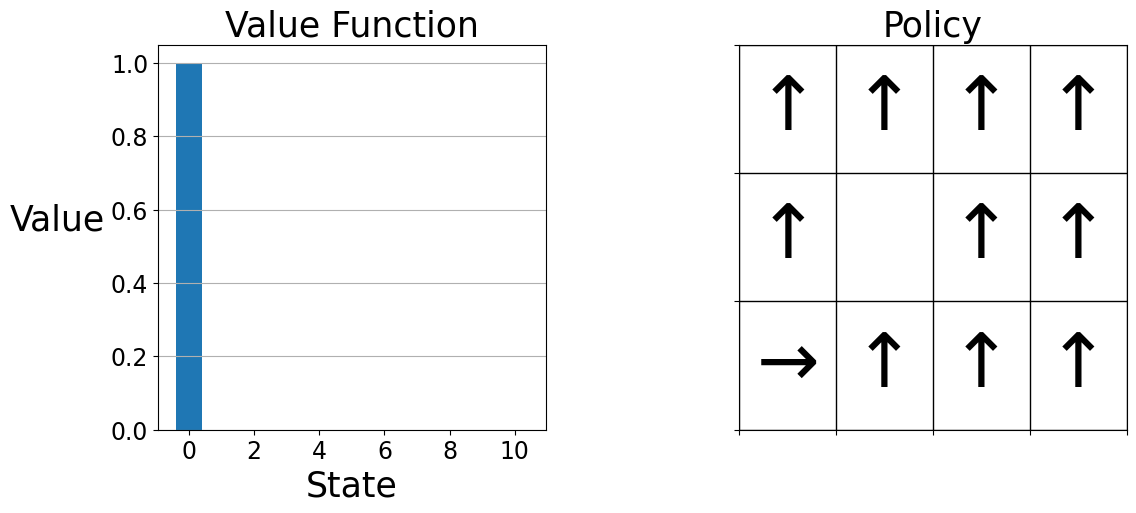

In [253]:
tools.plot(U, pi)

We can visualize a value function and policy with the `plot`
function in the `tools` module. On the left, the value function is displayed as a barplot. State zero has an a utility of one, while the other states have a utility of zero. On the right, the policy is displayed as arrows in each grid world state, denoting the four actions.

You can access the state space and the action set as attributes of the environment.

In [254]:
mdp.S

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [255]:

mdp.A

array([0, 1, 2, 3])

In [256]:
for s in mdp.S:
    print(f"State {s} is terminal: {mdp.terminal(s)}")

State 0 is terminal: False
State 1 is terminal: False
State 2 is terminal: False
State 3 is terminal: False
State 4 is terminal: False
State 5 is terminal: False
State 6 is terminal: True
State 7 is terminal: False
State 8 is terminal: False
State 9 is terminal: False
State 10 is terminal: True


You will need to use the environment's `transitions` method to complete this assignment. The method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [257]:
state = 6
action = 1
transitions = mdp.transitions(state, action)
transitions

array([[-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  1.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.],
       [-1.,  0.]])

In [258]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_} | S={state}, A={action}) = {p.round(3)}')

p(S'=0 | S=6, A=1) = 0.0
p(S'=1 | S=6, A=1) = 0.0
p(S'=2 | S=6, A=1) = 0.0
p(S'=3 | S=6, A=1) = 0.0
p(S'=4 | S=6, A=1) = 0.0
p(S'=5 | S=6, A=1) = 0.0
p(S'=6 | S=6, A=1) = 1.0
p(S'=7 | S=6, A=1) = 0.0
p(S'=8 | S=6, A=1) = 0.0
p(S'=9 | S=6, A=1) = 0.0
p(S'=10 | S=6, A=1) = 0.0


## Section 2: Policy Evaluation

Next, we'll be looking into how to compare and evaluate different policies. In our grid world example, an agent might act in different ways (with different $\pi$s) resulting in differing value functions. Background and detailed description are available in chapter 7.2 of the textbook(unless otherwise stated, chapters refer to *Algorithms for Decision Making*: https://algorithmsbook.com/).  We can do this through *policy evaluation*. Policy evaluation works by iteratively applying the Bellman equation for $U^{\pi}$ to a "working" value function, as an update rule, as shown below.

$$\large U_{k + 1}^{\pi}(s) \leftarrow R(s, \pi(s)) + \gamma  \sum_{s'} T(s' | s, \pi(s)) U^{\pi}_k(s')$$
<!-- This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. Further, note how this is the iterative (over states) form of the matrix based update introduced in the slides. -->

Implement both the `iterative_policy_evaluation` and `lookahead` functions below to complete the algorithm. The corresponding algorithms are provided in algorithms 7.2 and 7.3 in the text book.

In [259]:
# [GRADED]
def lookahead(mdp, U, s, a) -> float:
    """
    Find a new U according to the one-state look ahead.

    IMPORTANT NOTE: Remember that indices 6 and 10 are terminal states.
    This means gamma for any transition where the CURRENT state is
    a terminal state should be 0. Make use of the .terminal function!

    """

    G = 0

    ### START CODE HERE ###

    S, T, R, gamma = mdp.S, mdp.T, mdp.R, mdp.gamma
    effective_gamma = 0 if mdp.terminal(s) else gamma
    sum = 0

    for s_ in S:
      sum += U[s_] * T[a][s][s_]
    sum *= effective_gamma

    G = R[a, s] + sum

    ### END CODE HERE
    return G

In [280]:
# [GRADED]
def iterative_policy_evaluation(mdp, pi, k=1000) -> np.ndarray:
    """
    Iterative policy evaluation.
    This algorithm should iterate over k steps, and apply the `lookahead`
    function over all states at each step. Returns a numpy array.
    """
    U = np.zeros(mdp.state_size)
    ### START CODE HERE ###

    S, T, R, gamma = mdp.S, mdp.T, mdp.R, mdp.gamma
    print(R)

    for i in range(k):
        U_new = U.copy()
        for s in S:
          U_new[s] = lookahead(mdp, U, s, pi[s])
          U[s] = lookahead(mdp, U, s, pi[s])
        U = U_new
    ### END CODE HERE
    return U

The cell below uses the policy evaluation algorithm to evaluate the policy we defined above, which takes a LEFT action at the start state and will go UP in all other states.

In [281]:
U = iterative_policy_evaluation(mdp, pi)
U

[[ 0.   0.   0.  -0.8  0.  -0.1 -1.   0.   0.   0.1  1. ]
 [ 0.   0.   0.   0.   0.  -0.8 -1.   0.   0.   0.8  1. ]
 [ 0.   0.   0.   0.   0.  -0.1 -1.   0.   0.   0.1  1. ]
 [ 0.   0.   0.  -0.1  0.   0.  -1.   0.   0.   0.   1. ]]


array([ 0.10444847,  0.08120177,  0.14817925, -1.65567458,  0.12186104,
        0.40261362, -1.        ,  0.13878618,  0.29299306,  0.77274777,
        1.        ])

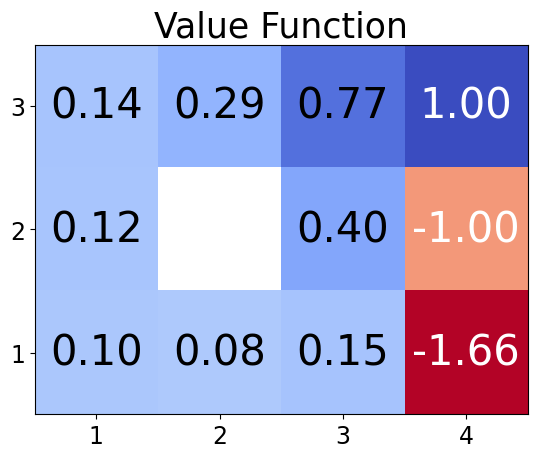

In [282]:
tools.plot_gridworld_u(U)

You can check the output (rounded to two decimal places) against the answer below:<br>
State $\quad\quad$    Value<br>
0 $\quad\quad\quad\;$        0.03<br>
1 $\quad\quad\quad\;$        0.03<br>
2 $\quad\quad\quad\;$        0.07<br>
3 $\quad\quad\quad\;$        -0.78<br>
4 $\quad\quad\quad\;$        0.06<br>
5 $\quad\quad\quad\;$        0.19<br>
6 $\quad\quad\quad\;$        -1.00<br>
7 $\quad\quad\quad\;$        0.07<br>
8 $\quad\quad\quad\;$        0.14<br>
9 $\quad\quad\quad\;$        0.37<br>
10 $\quad\quad\;\;\,\,$       1.00<br>

Recall that the value function represents the expected discounted returns following a given policy. Here are a few questions to consider:

#### GRADED
Questions:

2.1 Why is the value function not 0 in all places but the rewarding states if our policy almost always goes UP?

2.2 Why is the value of state index 1 smaller than state index 4?

2.3 Does this value function tell us anything about what might be the optimal policy?

## Section 3: Policy Iteration
Now it is time to improve our policy using policy iteration. Policy iteration alternates between evaluating the current policy and improving the policy by making it greedy with respect to the current value function. In this section, you will implement the policy iteration algorithm as described in Chapter 7.4 of the textbook.

In the policy improvement step, the policy is updated greedily using a one-step lookahead with the current value function $U^\pi$. Specifically, for each state $s$, the new policy selects the action that maximizes the Bellman backup:
$$\pi_{\text{new}}(s) = \arg\max_a \left[ R(s,a) + \gamma \sum_{s'} T(s' \mid s,a) U^\pi(s') \right]$$

You will make use of the policy evaluation routine ( `lookahead` ) implemented in Section 2. Implement the `greedy` function (corresponding to Algorithm 7.5 in the textbook) to compute the best action at a single state, and the `greedy_policy_over_U` function to construct the greedy policy over all states. Finally, combine these components in `policy_iteration` to complete the full policy iteration algorithm.

In [263]:
# [GRADED]
def greedy(mdp, U, s) -> int:
    """
    Find the best greedy action by looking ahead with ``U``.
    """
    ### START CODE HERE ###

    ### END CODE HERE ###

def greedy_policy_over_U(mdp, U):
    """
    Return the greedy policy w.r.t. a value function U. Returns a numpy array.
    """
    ### START CODE HERE ###

    ### END CODE HERE ###

def policy_iteration(mdp) -> tuple[np.ndarray, np.ndarray]:
    """
    Policy iteration. Refer to Algorithm 7.6 in the book. Returns a numpy array.
    We don't include k here, and just rely on the Ï€ == Ï€' condition to exit.
    Returns a tuple of two numpy arrays.
    """
    U = np.zeros(mdp.state_size)
    pi = np.zeros(mdp.state_size, dtype=int)

    ### START CODE HERE ###

    ### END CODE HERE ###

    return U, pi

When you are ready to test the policy iteration algorithm, run the cell below.

In [264]:
U, pi = policy_iteration(mdp)
U, pi

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

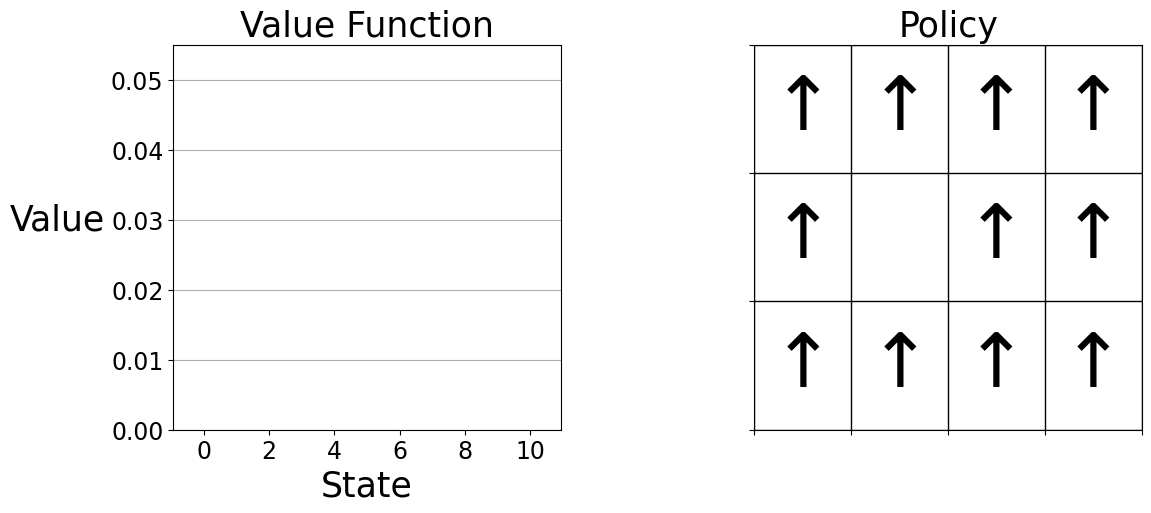

In [265]:
tools.plot(U, pi)

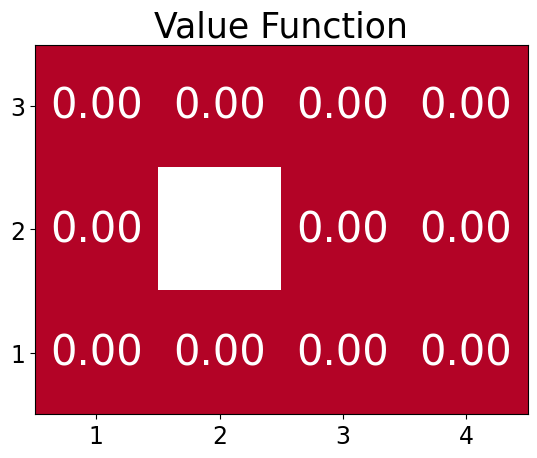

In [266]:
tools.plot_gridworld_u(U)

You can check the value function (rounded to two decimal places) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        0.49 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        0.43 $\quad\quad\;$ 3<br>
2 $\quad\quad\quad\;$        0.48 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        0.28 $\quad\quad\;$ 3<br>
4 $\quad\quad\quad\;$        0.57 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        0.57 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        -1.0 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        0.64 $\quad\quad\;$ 1<br>
8 $\quad\quad\quad\;$        0.74 $\quad\quad\;$ 1<br>
9 $\quad\quad\quad\;$        0.85 $\quad\quad\;$ 1<br>
10 $\quad\quad\;\;\,\,$      1.00 $\quad\quad\;$ 0<br>

### GRADED
Question:

3.1 How many iterations did it take for policy iteration to converge?

## Section 4: Value Iteration
Now we would like you to implement value iteration. Value iteration works by iteratively applying the Bellman update (equation 7.16) to a working value function, as an update rule, as shown below.

$$\large U_{k + 1}(s) \leftarrow \max_a \left[R(s, a) + \gamma \sum_{s'} T(s' | s, a)U_k(s')\right]$$
An outline of the value iteration algorithm is described in chapter 7.5 of the textbook. It is left to you to implement both the `value_iteration` and the `backup` function. The `backup` and `value_iteration` functions are presented in algorithms 7.7 and 7.8 of the textbook.

In [273]:
# [GRADED]
def backup(mdp, U, s) -> float:
    """
    Return the maximum backup value over all next actions.
    Refer to algorithm 7.7 in the book.
    """
    ### START CODE HERE ###

    ### END CODE HERE ###

def value_iteration(mdp, k=1000):
    """
    Value iteration. Refer to Algorithm 7.8 in the book.
    """
    U = np.zeros(mdp.state_size)
    pi = np.zeros((mdp.state_size), dtype=int)

    ### START CODE HERE ###


    ### END CODE HERE ###

    return U, pi

In [274]:
U, pi = value_iteration(mdp)
U, pi

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

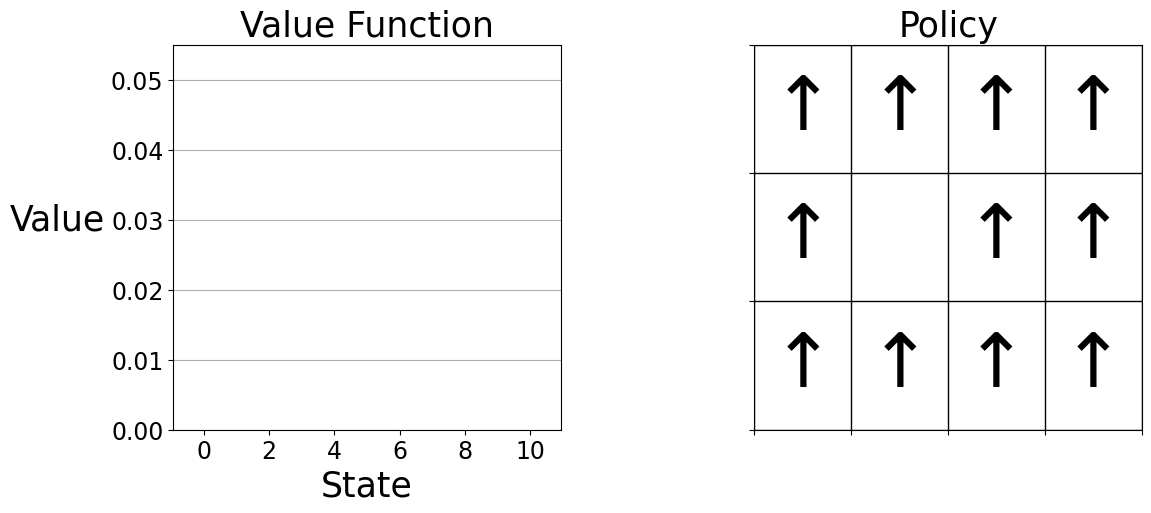

In [276]:
tools.plot(U, pi)

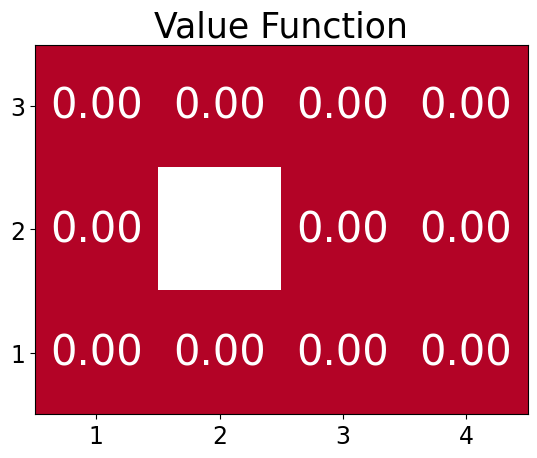

In [275]:
tools.plot_gridworld_u(U)

You can check the value function (rounded to two decimal places) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        0.49 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        0.43 $\quad\quad\;$ 3<br>
2 $\quad\quad\quad\;$        0.48 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        0.28 $\quad\quad\;$ 3<br>
4 $\quad\quad\quad\;$        0.57 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        0.57 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        -1.0 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        0.64 $\quad\quad\;$ 1<br>
8 $\quad\quad\quad\;$        0.74 $\quad\quad\;$ 1<br>
9 $\quad\quad\quad\;$        0.85 $\quad\quad\;$ 1<br>
10 $\quad\quad\;\;\,\,$      1.00 $\quad\quad\;$ 0<br>

Note here that the policy and value function learnt are the same!

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident.

In [271]:
def value_iteration2(mdp, k=1000):
    U = np.zeros(mdp.state_size)
    pi = np.zeros(mdp.state_size, dtype=int)
    for i in range(k):
        delta = 0
        for s in mdp.S:
            pi[s] = greedy(mdp, U, s)
            U[s] = lookahead(mdp, U, s, pi[s])

    return U, pi

You can try the second value iteration algorithm by running the cell below.

In [272]:
U, pi = value_iteration2(mdp)
tools.plot(U, pi)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

#### GRADED
From implementing policy and value iteration, and seeing this relationship between the two, answer the following questions:

4.1 At what iteration in `value_iteration2` does the action at state 7 change from its initialized action? (What is the first i at which pi[7] changes in the function `value_iteration2`)?

4.2  How would you interpret this? Why is it that the policy for state 7 changes at this value of i?


## Section 5: The Effects of Time Horizons

In this section, we explore the effects of gamma, the time horizon parameter of our MDP.

Below, we've run two more instances of value iteration on the grid world environment with 3 different discount factors (gammas).

In [ ]:
mdp_1 = copy.deepcopy(mdp)
mdp_1.gamma = 0.99

U_1, pi_1 = value_iteration(mdp_1)
tools.plot(U_1, pi_1)

#### GRADED
Question:

5.1 Explain the difference in policy between this policy and the policy learnt for $\gamma = 0.9$ in the original MDP.

In [ ]:
mdp_2 = copy.deepcopy(mdp)
mdp_2.gamma = 0.75

U_2, pi_2 = value_iteration(mdp_2)
tools.plot(U_2, pi_2)

#### GRADED
Question:

5.2 Explain the difference in policy between this policy and the policy learnt for $\gamma = 0.9$ in the original MDP. More specifically, why is it that the optimal policy for the agent at some states is different across the two policies?

## Section 6: Non-Monotonic Value Iteration Example

In the examples provided in the textbook and class, we have seen that initializing the values at 0 for value iteration leads to monotonicity. You can further see that the values change monotonically for both the hex environment in Figures 7.6 and Example 7.2 of the textbook. Formally, if we initialize all the values at zero, for all of these examples, we observe:
$$U_k(s) \leq U_{k + 1}(s) \text{ or } U_k(s) \geq U_{k + 1}(s), \forall k.$$
Meaning for a given state either the values increase monotonically or decrease monotonically. In these examples, with initializations at 0, the values across iterations never fluctuate between increasing and decreasing. To better understand how initialization effects value iteration, we would like you to find an example where the values dont change monotonically with the number of iterations for the MDP in this assignment. We provide examples of arbitrary monotonic and non-monotnics sequences below.

Examples of monotonic sequences:

1,2,3,4,5

0,-1,-2,-3,-4

Examples of non-monotic sequences:

1,2,3,4,3

5,4,3,2,4

An outline of the non-monotonic value iteration function is provided to you in `value_iteration_non_monotonic_example`. You have to construct an example with an initialization that leads to non-monotonicity. Return all the values (across all iterations) and the state for which we observe this non-monotonicity. The rest of the code can be same as what you have implemented for value_iteration (or Algorithm 7.8 in the textbook).

**Note:** We expect an example for the above mdp ($\gamma$=0.99) and therefore your code can be specific to this case including the indices and the initial values that you choose.

In [ ]:
# [GRADED]
def value_iteration_non_monotonic_example(mdp, k=100):
    """
    Value iteration that additionally returns U from ALL the iterations, ranging
    from 0 to k. It also returns the index of the state/block with
    non-monotonicity. Inputs are the same as above and therefore we describe
    the return values below:

    U: the optimal value function, same as value_iteration.
    Us: A numpy array of all the U functions over every iteration. The shape
    should be (k + 1, mdp.state_size). Note how this includes your
    initialization for U and therefore it is k + 1.
    pi: the optimal policy
    s_non_monotonic: the index corresponding to the state with non-monotonic
    values.
    """
    U = np.zeros(mdp.state_size) #initialize U differently
    pi = np.zeros((mdp.state_size), dtype=int)
    Us = []

    ### START CODE HERE ###

    ### END CODE HERE ###

    return U, np.array(Us), pi, s_non_monotonic

In [ ]:
mdp_all_Us = GridWorld()
mdp_all_Us.gamma = 0.99

_, Us, _, s_non_monotonic = value_iteration_non_monotonic_example(mdp_all_Us)

In [ ]:
tools.plot_log_U(Us[:, s_non_monotonic])

You can plot `log` U[s] over the iterations. With the right initialization, your graph should display non-monotonicity on the y-axis (log U).


## Section 7: Convergence and Auto-Stopping Value Iteration
In the previous sections, we ran Value Iteration for a fixed number of iterations. However, a key question in practice is: how many iterations are required to reach a specific level of accuracy?

Instead of running a fixed big number of iterations, we can stop the Value Iteration process when change in value function is
small from one iteration to the next, which is:
$$ \|U_n - U_{n-1}\| < \theta $$
where the maximum norm
$$\|U\|= \max_i|U_i|$$
and $\theta$ is very small.

Modify the Value Iteration algorithm to stop automatically when the maximum norm distance between two consecutive iterations ($\delta$) is less than a specified threshold $\theta$. Initialize $\delta$ to a large value. In each iteration, store a copy of the old values. Calculate $ \delta_n = \|U_n - U_{n-1}\| $. Append the $\delta_n$ you calculate each round to the array `deltas`. Stop when $\delta$ is less than $\theta$.

In [ ]:
# [GRADED]
def value_iteration_dynamic(mdp, theta=1e-6):
    """
    Value iteration that stops dynamically when the change is small.
    This algorithm continues to update the value function until the
    maximum change (Bellman residual) is below the threshold theta.

    Args:
        mdp: The MDP instance (GridWorld).
        theta: The stopping threshold for convergence.

    Returns:
        U: The final optimal value function (numpy array).
        pi: The optimal policy extracted from the final U (numpy array).
        deltas: A array containing the maximum change recorded at each iteration.
    """

    U = np.zeros(mdp.state_size)
    deltas = []

    ### START CODE HERE ###

    ### END CODE HERE ###

    # Extract policy
    pi = greedy_policy_over_U(mdp, U)
    return U, pi, np.array(deltas)

# Test your implementation
U, pi, deltas_for_plot = value_iteration_dynamic(mdp, theta=1e-6)

In [ ]:
tools.plot(U, pi)

In [ ]:
tools.plot_convergence(deltas_for_plot)

#### GRADED
Question:

7.1 Try different value of `mdp.gamma` and run your code. What is the relationship between `mdp.gamma` and the convergence iterations number required to stop?

7.2 In lectures, we emphasized the Contraction Property of Value Iteration algorithm, which is:
$$ \|U_0 - U^*\| \leq \epsilon \rightarrow \|U_n - U^*\| \leq \gamma^n\epsilon$$
Note that the True Value of the value function $U^*$ is a fixed point, meaning the value doesn't change with iteration.

If the algorithm you just implemented terminates because $\delta < \theta$, does it mean that we have found the exact $U^*$. Why is the contraction property essential for trusting that our estimate is close to the $U^*$?


##Section 8: Performance of a greedy policy under value- and reward-approximation
In all previous questions, we assumed that the reward function $R$ is known exactly. We now consider a more realistic setting in which the reward function can only be estimated and may be inaccurate.

Consider a discrete-time Markov Decision Process (MDP) with finite state space $S$ and finite action space $A$. Let $U^\star$ denote the optimal value function, and let $U_k$ be an approximate value function such that, for all $s \in S$,
$|U_k(s) - U^\star(s)| \le \varepsilon$.

Let $R$ be the true reward function and $\hat{R}$ be an estimated reward function satisfying, for all $s \in S$ and $a \in A$,
$|\hat{R}(s,a) - R(s,a)| \le \delta-\varepsilon$ where we assume $\delta > \varepsilon$.

Let $\pi$ be the greedy policy with respect to $U_k$, and let $U_\pi$ denote the value function induced by policy $\pi$.

GRADED:

**Approximate rewards:**  Provide an upper bound on $|U_\pi(s) - U^\star(s)|$ in terms of $\varepsilon$, $\delta$, and the discount factor $\gamma$. Your answer should include a rigorous mathematical proof.
 **Hint:**  If the reward function $R$ is known exactly (i.e., $\hat{R} = R$), the upper bound is $2 \epsilon \gamma /(1-\gamma)$, as shown in Chapter 7.5.


## Wrapping Up
Congratulations, you've completed assignment 1! In this assignment, we investigated policy evaluation and policy improvement, policy iteration and value iteration.

Please see the instructions on Ed for how to submit your work.